# Pre-processing & Modeling

In this notebook, the separate climate and energy subreddits are combined. They are reclassified into a boolean form where climate = 1 and energy = 0. Prior to modeling, sentiment analysis is undertaken to gain a better appreciation for the tone observed in the two subreddits. Finally, six models are run to identify the optimal production model for predicting whether text belongs either subreddit.

In [359]:
### Import libaries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [172]:
# Read in the climate csv
climate = pd.read_csv('../data/climate_df.csv')

In [173]:
climate.head()

,Unnamed: 0,subreddit,title,score,id,author
0,0,climate,How to Reach 100% Clean Energy By 2050?,1,eihfq4,SeekersThoughtsUP
1,1,climate,Prince William unveils 'Earthshot prize' to ta...,1,eihfqo,OldFashionedJizz
2,2,climate,How to talk to parents (late 60s / early 70s) ...,1,eijkdw,Hrafn2
3,3,climate,Shell made a film about climate change in 1991...,1,eijz9l,fungussa
4,4,climate,Climate And Energy For Dummies,1,eik0hm,CommonEmployment


In [330]:
# Read in the energy csv
energy = pd.read_csv('../data/energy_df.csv')

In [175]:
energy.head()

,Unnamed: 0,subreddit,title,score,id,author
0,0,energy,UAE minister and OPEC chief says IRENA’s solar...,1,eif1xg,Candid_Cryptographer
1,1,energy,Renewable electricity production in Germany in...,1,eigt4y,linknewtab
2,2,energy,Wyoming’s coal-fired economy is coming to an end,1,eihxsh,wainstead
3,3,energy,Trump administration says it will approve larg...,1,eijzgu,rieslingatkos
4,4,energy,Saudi Arabia Isn’t Getting Bullish About Oil f...,1,eikk81,Candid_Cryptographer


### Let's combine both subreddits, so that we can convert the data to a matrix representation

In [212]:
reddit = pd.concat([climate, energy]).reset_index(drop=True)

In [213]:
reddit.to_csv('../data/reddit.csv')

In [214]:
reddit.dtypes

Unnamed: 0     int64
subreddit     object
title         object
score          int64
id            object
author        object
dtype: object

### Map our 'subreddit' column into binary labels
1 for climate, 0 for energy

In [215]:
reddit['subreddit'] = reddit['subreddit'].map({'climate' :1, 'energy':0})
reddit.head()

,Unnamed: 0,subreddit,title,score,id,author
0,0,1,How to Reach 100% Clean Energy By 2050?,1,eihfq4,SeekersThoughtsUP
1,1,1,Prince William unveils 'Earthshot prize' to ta...,1,eihfqo,OldFashionedJizz
2,2,1,How to talk to parents (late 60s / early 70s) ...,1,eijkdw,Hrafn2
3,3,1,Shell made a film about climate change in 1991...,1,eijz9l,fungussa
4,4,1,Climate And Energy For Dummies,1,eik0hm,CommonEmployment


In [216]:
reddit.shape

(2400, 6)

## Sentiment Analyzer

#### Let's utilize Sentiment Analyzer to better understand the tone of posts associated with each subreddit.

In [293]:
sia = SentimentIntensityAnalyzer()

In [294]:
scores = []

for each in reddit['title']:
    current_scores = sia.polarity_scores(each)
    scores.append(current_scores)

In [295]:
scores_reddit = pd.DataFrame(scores)

In [296]:
scores_reddit

,neg,neu,pos,compound
0,0.000,0.459,0.541,0.5994
1,0.126,0.613,0.261,0.5267
2,0.000,1.000,0.000,0.0000
3,0.195,0.805,0.000,-0.5267
4,0.000,0.656,0.344,0.2732
...,...,...,...,...
2395,0.000,0.816,0.184,0.2023
2396,0.000,0.763,0.237,0.4215
2397,0.172,0.828,0.000,-0.4019
2398,0.113,0.887,0.000,-0.1027


#### Let's combine the sentiment scores with our main dataframe

In [298]:
new_df = pd.concat([X_test_df, y_test_df], axis =1)

In [299]:
sentiment_df = pd.concat([reddit, scores_reddit], axis=1)

In [300]:
sentiment_df.head()

,Unnamed: 0,subreddit,title,score,id,author,neg,neu,pos,compound
0,0,1,How to Reach 100% Clean Energy By 2050?,1,eihfq4,SeekersThoughtsUP,0.000,0.459,0.541,0.5994
1,1,1,Prince William unveils 'Earthshot prize' to ta...,1,eihfqo,OldFashionedJizz,0.126,0.613,0.261,0.5267
2,2,1,How to talk to parents (late 60s / early 70s) ...,1,eijkdw,Hrafn2,0.000,1.000,0.000,0.0000
3,3,1,Shell made a film about climate change in 1991...,1,eijz9l,fungussa,0.195,0.805,0.000,-0.5267
4,4,1,Climate And Energy For Dummies,1,eik0hm,CommonEmployment,0.000,0.656,0.344,0.2732


In [315]:
sentiment_df.drop(columns='Unnamed: 0').head()

,subreddit,title,score,id,author,neg,neu,pos,compound
0,1,How to Reach 100% Clean Energy By 2050?,1,eihfq4,SeekersThoughtsUP,0.000,0.459,0.541,0.5994
1,1,Prince William unveils 'Earthshot prize' to ta...,1,eihfqo,OldFashionedJizz,0.126,0.613,0.261,0.5267
2,1,How to talk to parents (late 60s / early 70s) ...,1,eijkdw,Hrafn2,0.000,1.000,0.000,0.0000
3,1,Shell made a film about climate change in 1991...,1,eijz9l,fungussa,0.195,0.805,0.000,-0.5267
4,1,Climate And Energy For Dummies,1,eik0hm,CommonEmployment,0.000,0.656,0.344,0.2732


#### To select sentiment of energy posts, let's create a unique dataframe

In [302]:
energy_sentiment = sentiment_df.loc[sentiment_df['subreddit'] == 0].sort_values(by='compound')

In [304]:
max_energy_sentiment = pd.DataFrame(energy_sentiment, columns = ['pos', 'neg', 'neu'])

#### For each row, we want to know the max sentiment score between positive, negative, and neutral language

In [305]:
# https://stackoverflow.com/questions/12169170/find-the-max-of-two-or-more-columns-with-pandas
max_energy_sentiment = max_energy_sentiment.idxmax(axis = 1)

In [306]:
max_energy_sentiment

1581    neu
1591    neg
1647    neg
2317    neu
2204    neu
       ... 
2265    neu
1580    pos
2164    neu
2151    neu
1307    neu
Length: 1200, dtype: object

#### Below, we can see that neutral posts make up the vast majority of posts. This is likely due to many of the posts being shared news headlines, which tend to lack bombastic opinion verbaige.

In [307]:
max_energy_sentiment.value_counts()

neu    1156
pos      30
neg      14
dtype: int64

In [308]:
max_energy_sentiment = pd.DataFrame(max_energy_sentiment)

In [312]:
max_energy_sentiment.value_counts(normalize=True)

neu    0.963333
pos    0.025000
neg    0.011667
dtype: float64

#### The below histogram better illustrates the dominance of neutral language on the energy subreddit.

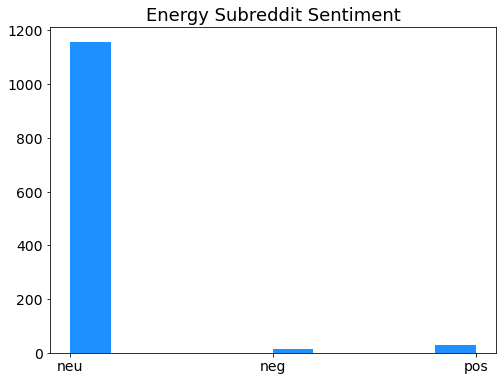

In [328]:
plt.figure(figsize=(8,6))


plt.hist(max_energy_sentiment[0], color = 'dodgerblue');
plt.title('Energy Subreddit Sentiment', fontsize=18);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

#### Now let's take a look at sentiment within the climate subreddit

In [229]:
climate_sentiment = sentiment_df.loc[sentiment_df['subreddit'] == 1].sort_values(by='compound')

In [285]:
max_climate_sentiment = pd.DataFrame(climate_sentiment, columns = ['pos', 'neg', 'neu'])

#### Following a similar workflow as above, we will find the max sentiment by row between positive, negative, and neutral verbiage.

In [286]:
# https://stackoverflow.com/questions/12169170/find-the-max-of-two-or-more-columns-with-pandas
max_climate_sentiment = max_climate_sentiment.idxmax(axis = 1)

In [332]:
max_climate_sentiment

,0
758,neu
6,neu
188,neu
345,neg
1146,neg
...,...
1143,neu
284,neu
872,neu
684,neu


#### Below, we can see a similar trend as with the energy subreddit. Neutral language domiantes.

In [288]:
max_climate_sentiment.value_counts()

neu    1162
neg      19
pos      19
dtype: int64

In [289]:
max_climate_sentiment = pd.DataFrame(max_climate_sentiment)

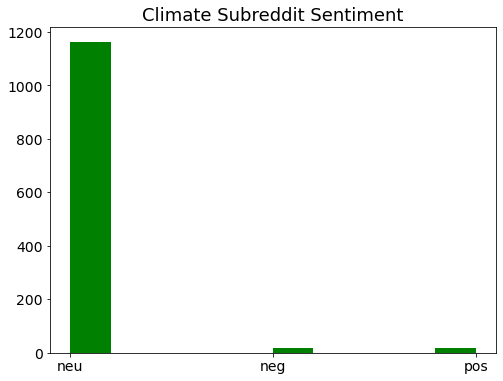

In [327]:
plt.figure(figsize=(8,6))


plt.hist(max_climate_sentiment[0], color ='green');
plt.title('Climate Subreddit Sentiment', fontsize=18);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

In [314]:
max_climate_sentiment.value_counts(normalize=True)

neu    0.968333
pos    0.015833
neg    0.015833
dtype: float64

# Classification Modeling

In [331]:
#### Below are six models tasked with classifying our climate and energy subreddits. We will use a combination of transformers (CountVectorizer, TF-IDF Vectorizer) and estimators (Logistic Regression, K-Nearest Neighbor, Multinomial Naive Bayes, and Random Forest) to best classify the text from our posts.

### Define our X & y

In [333]:
X = reddit['title']
y= reddit['subreddit']

In [334]:
y.value_counts(normalize = True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

### Split the data into training and testing

In [335]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

#### Establish baseline accuracy

In [337]:
y_test.value_counts(normalize=True)

1    0.505
0    0.495
Name: subreddit, dtype: float64

### Instantiate a CountVectorizer with the default hyperparameters

Before instantiating CountVectorizer, let's create a custom stop_words based on our EDA. This will remove 'energy', 'climate', and 'change' from our corpus.

In [36]:
stops = ['climate', 'change', 'energy']

In [37]:
# Credit to https://stackoverflow.com/questions/24386489/adding-words-to-scikit-learns-countvectorizers-stop-list
stop_words = text.ENGLISH_STOP_WORDS.union(stops)


In [38]:
cvec = CountVectorizer(stop_words = stop_words)

### Fit the vectorizer on our corpus

In [39]:
cvec.fit(X_train)

CountVectorizer(stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}))

### Transform the corpus
First let's transform X_train

In [40]:
X_train = cvec.transform(X_train)

In [41]:
X_train

<1800x5434 sparse matrix of type '<class 'numpy.int64'>'
	with 16726 stored elements in Compressed Sparse Row format>

In [42]:
X_train.shape

(1800, 5434)

Now transform X_test

In [43]:
X_test = cvec.transform(X_test)

### With our data transformed, let's evaluate a simple logistic regression model

In [44]:
 # Instantiate the model
logreg = LogisticRegression()

In [45]:
# Fit our model
logreg.fit(X_train, y_train)

LogisticRegression()

In [46]:
# Generate predicted values
logreg.predict(X_test)[:10]

array([0, 0, 1, 0, 0, 1, 1, 1, 0, 1])

In [47]:
# Evaluate our model
print(f"The training score of our logistic regression model is: {logreg.score(X_train, y_train)}")
print(f"The testing score of our logistic regression model is: {logreg.score(X_test, y_test)}")

The training score of our logistic regression model is: 0.9644444444444444
The testing score of our logistic regression model is: 0.7766666666666666


Above, we can see our model is very overfit based on the large delta between our training and testing scores. Let's incorporate a pipeline and gridsearch to better optimize our model hyperparameters.

## Model 1 - CVEC & Logistic Regression

In [343]:
# Redefine training and testing
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [344]:
pipe_1 = Pipeline([
    ('cvec_1', CountVectorizer()),
    ('logreg_1', LogisticRegression())
])

In [347]:
#Estimate how your model will perform on unseen data
cross_val_score(pipe_1, X_train, y_train, cv=3).mean() 


0.8116666666666665

In [349]:
# Evaluate our model
print(f"The training score of our logistic regression model is: {pipe_1.score(X_train, y_train)}")
print(f"The testing score of our logistic regression model is: {pipe_1.score(X_test, y_test)}")

The training score of our logistic regression model is: 0.9705555555555555
The testing score of our logistic regression model is: 0.795


### Let's load pipe_1 into the gridsearch

In [350]:
# Search over the following values of hyperparameters:
# Stopwords parameters include None and our custom list of english stop words + climate, change, and energy
# Maximum number of features fit: 1000, 2000, 3000, 4000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%


pipe_1_params = {
    'cvec_1__stop_words': [stop_words, None],
    'cvec_1__max_features': [1000, 2000, 3000, 4000, None],
    'cvec_1__min_df': [2, 3],
    'cvec_1__max_df': [.9, .95],
}


In [351]:
# Instantiate GridSearch
gs_1 = GridSearchCV(pipe_1,
                   param_grid = pipe_1_params,
                   cv=5)

In [352]:
gs_1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec_1', CountVectorizer()),
                                       ('logreg_1', LogisticRegression())]),
             param_grid={'cvec_1__max_df': [0.9, 0.95],
                         'cvec_1__max_features': [1000, 2000, 3000, 4000, None],
                         'cvec_1__min_df': [2, 3],
                         'cvec_1__stop_words': [frozenset({'a', 'about',
                                                           'above', 'across',
                                                           'after',
                                                           'afterwards',
                                                           'again', 'against',
                                                           'all', 'almost',
                                                           'alone', 'along',
                                                           'already', 'also',
                                            

In [353]:
gs_1.best_params_

{'cvec_1__max_df': 0.9,
 'cvec_1__max_features': 3000,
 'cvec_1__min_df': 2,
 'cvec_1__stop_words': None}

In [354]:
print(gs_1.best_score_)

0.8238888888888889


In [391]:
print(f'Our training score is {gs_1.score(X_train, y_train)}')
print(f'Our testing score is {gs_1.score(X_test, y_test)}')

Our training score is 0.9583333333333334
Our testing score is 0.8016666666666666


#### Above, we can see our model is quite overfit. Based on our testing scores, we can see that our model is 80% accurate.

In [357]:
# Get predictions
preds_1 = gs_1.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_1).ravel()

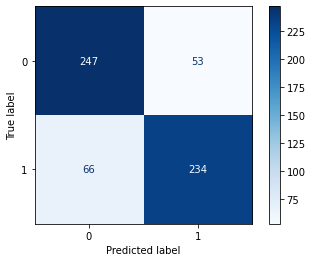

In [434]:
plot_confusion_matrix(gs_1, X_test, y_test, cmap='Blues', values_format='d');

The above confusion matrix provides a visualization of our predictions versus the actual data.

## Model 2 - CVEC & KNN

In [420]:
# Redefine training and testing
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [421]:
pipe_2 = Pipeline([
    ('cvec_2', CountVectorizer()),
    ('knn_1', KNeighborsClassifier())
])

In [422]:
#Estimate how your model will perform on unseen data
cross_val_score(pipe_2, X_train, y_train, cv=3).mean() 

# Fit your model
pipe_2.fit(X_train, y_train)

Pipeline(steps=[('cvec_2', CountVectorizer()),
                ('knn_1', KNeighborsClassifier())])

In [423]:
# Evaluate our model
print(f"The training score of our KNN model is: {pipe_2.score(X_train, y_train)}")
print(f"The testing score of our KNN model is: {pipe_2.score(X_test, y_test)}")

The training score of our KNN model is: 0.8183333333333334
The testing score of our KNN model is: 0.675


#### Let's load pipe_2 into the gridsearch

In [424]:
# Search over the following values of hyperparameters:
# Stopwords parameters include None and our custom list of english stop words + climate, change, and energy
# Maximum number of features fit: 1000, 2000, 3000, 4000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%


pipe_2_params = {
    'cvec_2__stop_words': [stop_words, stops, None],
    'cvec_2__max_features': [1000, 2000, 3000, 4000],
    'cvec_2__min_df': [2, 3],
    'cvec_2__max_df': [.9, .95],
    'knn_1__p': [1, 2],
    'knn_1__weights': ['uniform', 'distance'],
    'knn_1__n_neighbors': [3, 5, 10]
}


In [425]:
# Instantiate GridSearch
gs_2 = GridSearchCV(pipe_2,
                   pipe_2_params,
                   cv=5)

In [426]:
gs_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec_2', CountVectorizer()),
                                       ('knn_1', KNeighborsClassifier())]),
             param_grid={'cvec_2__max_df': [0.9, 0.95],
                         'cvec_2__max_features': [1000, 2000, 3000, 4000],
                         'cvec_2__min_df': [2, 3],
                         'cvec_2__stop_words': [frozenset({'a', 'about',
                                                           'above', 'across',
                                                           'after',
                                                           'afterwards',
                                                           'again', 'against',
                                                           'all', 'almost',
                                                           'alone', 'along',
                                                           'already', 'also',
                                                   

In [427]:
gs_2.best_params_

{'cvec_2__max_df': 0.9,
 'cvec_2__max_features': 2000,
 'cvec_2__min_df': 2,
 'cvec_2__stop_words': None,
 'knn_1__n_neighbors': 10,
 'knn_1__p': 2,
 'knn_1__weights': 'distance'}

In [428]:
print(gs_2.best_score_)

0.696111111111111


In [433]:
print(f'Our training score is {gs_2.score(X_train, y_train)}')
print(f'Our testing score is {gs_2.score(X_test, y_test)}')

Our training score is 0.9838888888888889
Our testing score is 0.6816666666666666


#### Based on the above scores, our model is very overefit. Additionally, the accuracy score of 68% implies this model is the least accurate in predicting which subreddit our text originates from.

In [431]:
# Get predictions
preds_2 = gs_2.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_2).ravel()

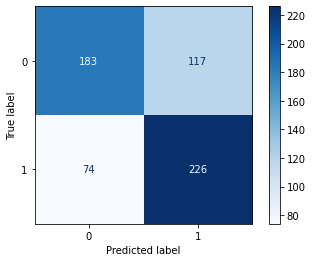

In [432]:
# visualize this

plot_confusion_matrix(gs_2, X_test, y_test, cmap='Blues', values_format='d');

## Model 3 - Tfidf & Logistic Regression

In [364]:
# Redefine training and testing
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [365]:
pipe_3 = Pipeline([
    ('tvec_1', TfidfVectorizer()),
    ('logreg_2', LogisticRegression())
])

In [366]:
#Estimate how your model will perform on unseen data
cross_val_score(pipe_3, X_train, y_train, cv=3).mean() 

# Fit your model
pipe_3.fit(X_train, y_train)

Pipeline(steps=[('tvec_1', TfidfVectorizer()),
                ('logreg_2', LogisticRegression())])

In [367]:
# Evaluate our model
print(f"The training score of our logistic regression model is: {pipe_3.score(X_train, y_train)}")
print(f"The testing score of our logistic regression model is: {pipe_3.score(X_test, y_test)}")

The training score of our logistic regression model is: 0.9338888888888889
The testing score of our logistic regression model is: 0.845


#### Let's load pipe_3 into the gridsearch

In [443]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 1000, 2000, 3000, 4000, and None
# Minimum number of documents needed to include token: 2, 3
# No stop words and stop_words list
# Check (individual tokens) and also check (individual tokens and 2-grams).
# Maximum number of documents needed to include token: 90%, 95%


pipe_3_params = {
    'tvec_1__stop_words': [stops, stop_words, None],
    'tvec_1__max_features': [1000, 2000, 3000, 4000, None],
    'tvec_1__min_df': [2, 3, 4],
    'tvec_1__max_df': [.9, .95],
    'tvec_1__ngram_range': [(1,1), (1,2)]
}


In [444]:
# Instantiate GridSearch
gs_3 = GridSearchCV(pipe_3,
                   pipe_3_params,
                   cv=5)

In [445]:
gs_3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec_1', TfidfVectorizer()),
                                       ('logreg_2', LogisticRegression())]),
             param_grid={'tvec_1__max_df': [0.9, 0.95],
                         'tvec_1__max_features': [1000, 2000, 3000, 4000, None],
                         'tvec_1__min_df': [2, 3, 4],
                         'tvec_1__ngram_range': [(1, 1), (1, 2)],
                         'tvec_1__stop_words': [['climate', 'change', 'energy'],
                                                frozenset({'a', 'about',
                                                           'above', 'across',
                                                           'after',
                                                           'afterwards',
                                                           'again', 'against',
                                                           'all', 'almost',
                                                 

In [446]:
gs_3.best_params_

{'tvec_1__max_df': 0.9,
 'tvec_1__max_features': 2000,
 'tvec_1__min_df': 3,
 'tvec_1__ngram_range': (1, 1),
 'tvec_1__stop_words': None}

In [439]:
print(gs_3.best_score_)

0.8366666666666667


In [440]:
gs_3.score(X_train, y_train)

0.915

In [441]:
gs_3.score(X_test, y_test)

0.8483333333333334

In [442]:
print(f'Our training score is {gs_3.score(X_train, y_train)}')
print(f'Our testing score is {gs_3.score(X_test, y_test)}')

Our training score is 0.915
Our testing score is 0.8483333333333334


#### We can see above that our model is improving, but still overfit. This current model has an accuracy of 85%.

In [377]:
# Get predictions
y_preds_3 = gs_3.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_3).ravel()

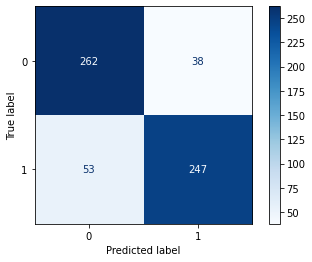

In [378]:
# visualize this

plot_confusion_matrix(gs_3, X_test, y_test, cmap='Blues', values_format='d');

### Model 3 Feature Importance

To better understand the major contributors toward our model's ability to predict the correct subreddit, let's identify the coefficients of our features.

In [411]:
# Workflow credited to - https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214

In [393]:
pipe_3_features = pipe_3.named_steps['tvec_1'].get_feature_names()

In [394]:
pipe_3_coefs = pipe_3.named_steps['logreg_2'].coef_.flatten()

In [397]:
pipe_3_zip = zip(pipe_3_features, pipe_3_coefs)

In [398]:
pipe_3_df = pd.DataFrame(pipe_3_zip, columns = ['features', 'coefficients'])

In [399]:
pipe_3_df.head()

,features,coefficients
0,00,-0.078503
1,000,0.530620
2,01,-0.044130
3,02,0.139450
4,03,0.232133


In [400]:
pipe_3_df["abs_value"] = pipe_3_df["coefficients"].apply(lambda x: abs(x))

In [406]:
pipe_3_df["colors"] = pipe_3_df["coefficients"].apply(lambda x: "green" if x > 0 else "dodgerblue")

In [407]:
pipe_3_df = pipe_3_df.sort_values("abs_value", ascending=False)

In [408]:
pipe_3_df

,features,coefficients,abs_value,colors
1070,climate,7.078965,7.078965,green
2598,hydrogen,-3.502664,3.502664,dodgerblue
1820,energy,-3.398008,3.398008,dodgerblue
988,change,2.936023,2.936023,green
4731,solar,-2.836885,2.836885,dodgerblue
...,...,...,...,...
1240,contributing,0.000783,0.000783,green
1305,covid,0.000490,0.000490,green
4335,revolutionary,0.000247,0.000247,green
2710,information,0.000243,0.000243,green


Text(0.5, 0, 'Feature Name')

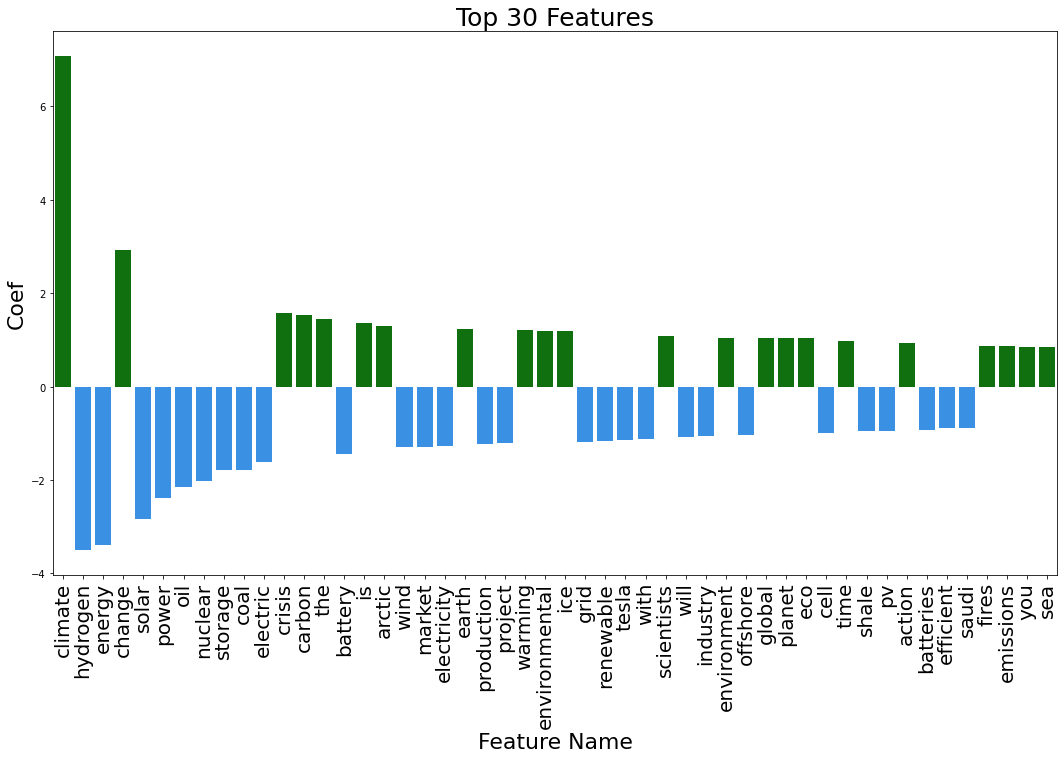

In [409]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10))
sns.barplot(x='features',
            y='coefficients',
            data=pipe_3_df.head(50),
           palette=pipe_3_df.head(50)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 30 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

In [416]:
gs_3.predict(['coal is good for the environment'])

array([1])

Above, we can see the top 30 features contributing towards our model's ability to predict a given subreddit. Climate itself has the greatest coefficient, which is not particularly suprising. While this feature has the highest absolute value of all features, we can see that features predicting energy dominate nine of the next ten most influential features.

### Model 3 Misclassifiation

Let's first combine our target column with our predictions.

Credit for collaboration on this process is attributed to Alec Edgecliffe-Johnson. We also found inspiration from Caroline Schmitt's lesson code.

In [104]:
y_test_np = np.asarray(y_test)

In [116]:
y_test_df = pd.DataFrame(y_test).copy()

In [117]:
X_test_df = pd.DataFrame(X_test).copy()

In [118]:
y_test_df['preds'] = y_preds_3

In [119]:
y_test_df

,subreddit,preds
469,0,0
812,1,0
520,1,1
888,1,0
1149,1,0
...,...,...
415,1,1
1111,1,0
779,0,0
187,1,1


Now, we can combine our target column, predictions, and the contents of their associated posts.

In [122]:
new_df = pd.concat([X_test_df, y_test_df], axis =1)

In [123]:
new_df.head()

,title,subreddit,preds
469,Meet the New Flack for Oil and Gas: Michael Moore,0,0
812,Groups pressure Biden to exclude fossil fuel e...,1,0
520,Science denialism: How Climate Change paved th...,1,1
888,When Elephants Attack,1,0
1149,Virtual sports on Wazobet | Virtual Greyhounds...,1,0


In [124]:
new_df['subtract'] = new_df['preds'] - new_df['subreddit']

In [125]:
only_misclass = new_df.loc[new_df['subtract'] != 0]

In [126]:
only_misclass.head()

,title,subreddit,preds,subtract
812,Groups pressure Biden to exclude fossil fuel e...,1,0,-1
888,When Elephants Attack,1,0,-1
1149,Virtual sports on Wazobet | Virtual Greyhounds...,1,0,-1
252,Comment below what you think 🤑🤫 What is more c...,0,1,1
766,Two of Biden's veep contenders roll out enviro...,0,1,1


In [129]:
only_misclass.shape

(91, 4)

To dive in deeper on what may be causing misclassification, let's remove the common features - climate, change, and energy.

In [144]:
stops = ['climate', 'change', 'energy']

In [145]:
# Credit to https://stackoverflow.com/questions/24386489/adding-words-to-scikit-learns-countvectorizers-stop-list
stop_words = text.ENGLISH_STOP_WORDS.union(stops)

In [152]:
#Instantiate a new CV
cvec_misclass = CountVectorizer(stop_words = stop_words)

In [153]:
cvec_misclass.fit(only_misclass['title'])

CountVectorizer(stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}))

In [154]:
misclass_title = cvec_misclass.transform(only_misclass['title'])

In [155]:
misclass_title_df = pd.DataFrame(misclass_title.todense(),
                                columns=cvec_misclass.get_feature_names())

Text(0.5, 0, 'Word Count')

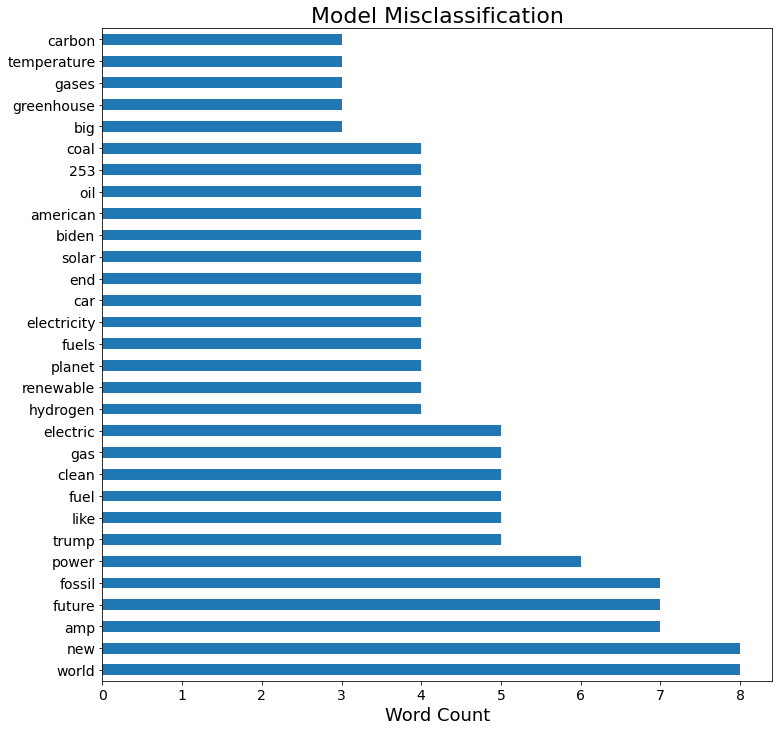

In [414]:
plt.figure(figsize=(12,12))
misclass_title_df.sum().sort_values(ascending=False).head(30).plot(kind='barh');

plt.title('Model Misclassification', fontsize=22);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.xlabel('Word Count', fontsize=18)

Above, we can see many of the commonly misclassified words are associated with energy topics. Within the context of the problem statement and it's focus on education, this could indicate that many users are using energy topics in an uninformed manner.

## Pipe 4 - Tfidf & Multinomial Naive Bayes

In [449]:
# Redefine training and testing
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [450]:
pipe_4 = Pipeline([
    ('tvec_2', TfidfVectorizer()),
    ('nb_1', MultinomialNB())
])

In [451]:
#Estimate how your model will perform on unseen data
cross_val_score(pipe_4, X_train, y_train, cv=3).mean() 

# Fit your model
pipe_4.fit(X_train, y_train)

Pipeline(steps=[('tvec_2', TfidfVectorizer()), ('nb_1', MultinomialNB())])

In [452]:
# Evaluate our model
print(f"The training score of our logistic regression model is: {pipe_4.score(X_train, y_train)}")
print(f"The testing score of our logistic regression model is: {pipe_4.score(X_test, y_test)}")

The training score of our logistic regression model is: 0.9433333333333334
The testing score of our logistic regression model is: 0.8166666666666667


### Let's load pipe_4 into the gridsearch

In [453]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 1000, 2000, 3000, 4000, and None
# Minimum number of documents needed to include token: 2, 3
# No stop words and stop_words list
# Check (individual tokens) and also check (individual tokens and 2-grams).
# Maximum number of documents needed to include token: 90%, 95%


pipe_4_params = {
    'tvec_2__stop_words': [stop_words, None],
    'tvec_2__max_features': [1000, 2000, 3000, 4000, None],
    'tvec_2__min_df': [2, 3],
    'tvec_2__max_df': [.9, .95],
    'tvec_2__ngram_range': [(1,1), (1,2)]
}


In [454]:
# Instantiate GridSearch
gs_4 = GridSearchCV(pipe_4,
                   pipe_4_params,
                   cv=5)

In [455]:
gs_4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec_2', TfidfVectorizer()),
                                       ('nb_1', MultinomialNB())]),
             param_grid={'tvec_2__max_df': [0.9, 0.95],
                         'tvec_2__max_features': [1000, 2000, 3000, 4000, None],
                         'tvec_2__min_df': [2, 3],
                         'tvec_2__ngram_range': [(1, 1), (1, 2)],
                         'tvec_2__stop_words': [frozenset({'a', 'about',
                                                           'above', 'across',
                                                           'after',
                                                           'afterwards',
                                                           'again', 'against',
                                                           'all', 'almost',
                                                           'alone', 'along',
                                                           'alrea

In [456]:
gs_4.best_params_

{'tvec_2__max_df': 0.9,
 'tvec_2__max_features': 3000,
 'tvec_2__min_df': 2,
 'tvec_2__ngram_range': (1, 2),
 'tvec_2__stop_words': None}

In [457]:
print(gs_4.best_score_)

0.8338888888888889


In [460]:
# Evaluate our model
print(f"The training score of our logistic regression model is: {gs_4.score(X_train, y_train)}")
print(f"The testing score of our logistic regression model is: {gs_4.score(X_test, y_test)}")

The training score of our logistic regression model is: 0.9127777777777778
The testing score of our logistic regression model is: 0.815


In [246]:
# Get predictions
preds = gs_4.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()


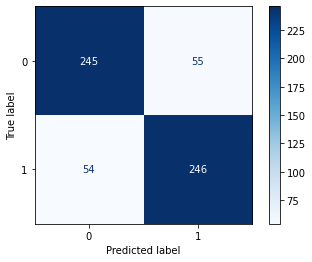

In [247]:
# visualize this

plot_confusion_matrix(gs_4, X_test, y_test, cmap='Blues', values_format='d');

## Pipe 5 - CVEC & Multinomial Naive Bayes

In [461]:
# Redefine training and testing
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [462]:
pipe_5 = Pipeline([
    ('cvec_3', CountVectorizer()),
    ('nb_2', MultinomialNB())
])

In [463]:
#Estimate how your model will perform on unseen data
cross_val_score(pipe_5, X_train, y_train, cv=3).mean() 

# Fit your model
pipe_5.fit(X_train, y_train)

Pipeline(steps=[('cvec_3', CountVectorizer()), ('nb_2', MultinomialNB())])

In [464]:
# Evaluate our model
print(f"The training score of our logistic regression model is: {pipe_5.score(X_train, y_train)}")
print(f"The testing score of our logistic regression model is: {pipe_5.score(X_test, y_test)}")

The training score of our logistic regression model is: 0.94
The testing score of our logistic regression model is: 0.84


### Let's load pipe_5 into the gridsearch

In [465]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 1000, 2000, 3000, 4000, and None
# Minimum number of documents needed to include token: 2, 3
# No stop words and stop_words list
# Check (individual tokens) and also check (individual tokens and 2-grams).
# Maximum number of documents needed to include token: 90%, 95%


pipe_5_params = {
    'cvec_3__stop_words': [stop_words, None],
    'cvec_3__max_features': [1000, 2000, 3000, 4000, None],
    'cvec_3__min_df': [2, 3],
    'cvec_3__max_df': [.9, .95],
    'cvec_3__ngram_range': [(1,1), (1,2)]
}


In [466]:
# Instantiate GridSearch
gs_5 = GridSearchCV(pipe_5,
                   pipe_5_params,
                   cv=5)

In [467]:
gs_5.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec_3', CountVectorizer()),
                                       ('nb_2', MultinomialNB())]),
             param_grid={'cvec_3__max_df': [0.9, 0.95],
                         'cvec_3__max_features': [1000, 2000, 3000, 4000, None],
                         'cvec_3__min_df': [2, 3],
                         'cvec_3__ngram_range': [(1, 1), (1, 2)],
                         'cvec_3__stop_words': [frozenset({'a', 'about',
                                                           'above', 'across',
                                                           'after',
                                                           'afterwards',
                                                           'again', 'against',
                                                           'all', 'almost',
                                                           'alone', 'along',
                                                           'alrea

In [468]:
gs_5.best_params_

{'cvec_3__max_df': 0.9,
 'cvec_3__max_features': 4000,
 'cvec_3__min_df': 2,
 'cvec_3__ngram_range': (1, 2),
 'cvec_3__stop_words': None}

In [469]:
print(gs_5.best_score_)

0.836111111111111


In [471]:
# Evaluate our model
print(f"The training score of our logistic regression model is: {gs_5.score(X_train, y_train)}")
print(f"The testing score of our logistic regression model is: {gs_5.score(X_test, y_test)}")

The training score of our logistic regression model is: 0.9133333333333333
The testing score of our logistic regression model is: 0.8066666666666666


In [276]:
# Get predictions
preds = gs_5.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()


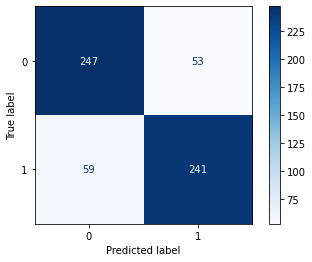

In [277]:
# visualize this

plot_confusion_matrix(gs_5, X_test, y_test, cmap='Blues', values_format='d');

# Model 6 - CVEC & Random Forest

In [472]:
# Redefine training and testing
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [473]:
pipe_6 = Pipeline([
    ('cvec_4', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [474]:
#Estimate how your model will perform on unseen data
cross_val_score(pipe_6, X_train, y_train, cv=3).mean() 

# Fit your model
pipe_6.fit(X_train, y_train)

Pipeline(steps=[('cvec_4', CountVectorizer()),
                ('rf', RandomForestClassifier())])

In [475]:
# Evaluate our model
print(f"The training score of our logistic regression model is: {pipe_6.score(X_train, y_train)}")
print(f"The testing score of our logistic regression model is: {pipe_6.score(X_test, y_test)}")

The training score of our logistic regression model is: 0.9877777777777778
The testing score of our logistic regression model is: 0.825


### Let's load pipe_6 into the gridsearch

In [476]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 1000, 2000, 3000, 4000, and None
# Minimum number of documents needed to include token: 2, 3
# No stop words and stop_words list
# Check (individual tokens) and also check (individual tokens and 2-grams).
# Maximum number of documents needed to include token: 90%, 95%


pipe_6_params = {
    'cvec_4__stop_words': [stop_words, None],
    'cvec_4__max_features': [1000, 2000, 3000, 4000, None],
    'cvec_4__min_df': [2, 3],
    'cvec_4__max_df': [.9, .95],
    'cvec_4__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 1, 2, 3, 4, 5],
}


In [477]:
# Instantiate GridSearch
gs_6 = GridSearchCV(pipe_6,
                   pipe_6_params,
                   cv=5)

In [478]:
gs_6.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec_4', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'cvec_4__max_df': [0.9, 0.95],
                         'cvec_4__max_features': [1000, 2000, 3000, 4000, None],
                         'cvec_4__min_df': [2, 3],
                         'cvec_4__ngram_range': [(1, 1), (1, 2)],
                         'cvec_4__stop_words': [frozenset({'a', 'about',
                                                           'above', 'across',
                                                           'after',
                                                           'afterwards',
                                                           'again', 'against',
                                                           'all', 'almost',
                                                           'alone', 'along',
                                                          

In [479]:
gs_6.best_params_

{'cvec_4__max_df': 0.95,
 'cvec_4__max_features': 4000,
 'cvec_4__min_df': 3,
 'cvec_4__ngram_range': (1, 1),
 'cvec_4__stop_words': None,
 'rf__max_depth': 5,
 'rf__n_estimators': 100}

In [480]:
print(gs_6.best_score_)

0.8233333333333333


In [481]:
# Evaluate our model
print(f"The training score of our logistic regression model is: {gs_6.score(X_train, y_train)}")
print(f"The testing score of our logistic regression model is: {gs_6.score(X_test, y_test)}")

The training score of our logistic regression model is: 0.8388888888888889
The testing score of our logistic regression model is: 0.795


In [484]:
# Get predictions
preds = gs_6.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()


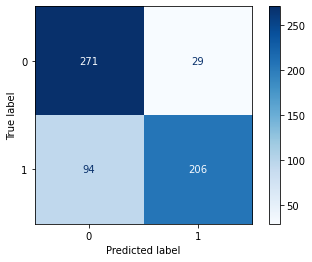

In [485]:
# visualize this

plot_confusion_matrix(gs_6, X_test, y_test, cmap='Blues', values_format='d');

# Conclusions

With the stated goal of better understanding the climate and energy subreddits, the analysis presented herein effectively identifies trends in word usage and sentiment. Over a span of six models, we were able to identify the best performing, which is the TF-IDF transformer and logistic regression estimator. This model yielded an accuracy of 85% on our testing data.

We identified misclassified words, which will help better frame our topics in our upcoming book covering the nexus of climate and energy. The misclassified words tended to be more focused on energy topics. By better understanding where knowledge gaps may occur, we can attempt to provide useful information for closing the gap between climate and energy.

Further research should be undertaken within topics specific to energy and climate, respectively, such that more informed conclusions can be presented to future readers of our educational work.